In [1]:
from collections import Counter
from gensim.corpora import Dictionary
from nltk import ngrams
from scipy import stats

import itertools
import numpy as np
import os
import pybo

import matplotlib.pyplot as plt
%matplotlib inline

Store texts in the following directory structure:

    texts
      Bon
        file1.txt
        file2.txt
        ...
      Nyingma
        file1.txt
        file2.txt
        ...

In [2]:
tok = pybo.BoTokenizer('POS')

Loading Trie...
Time: 3.2658262252807617


Assumptions here:
1. Drop all non-bo text
2. Drop all phrase delimiters (shad)
3. Reduce words to lemmas
4. Strip beginning and ending tseks from lemmas

In [3]:
tsek = '་'

# Create dictionary to map document index back to filename
bon_idx2fname = {}
bon_texts = []
for filename in sorted(os.listdir("texts/Bon")):
    if ".txt" in filename:
        with open("texts/Bon/" + filename, 'r', encoding='utf-8-sig') as f:
            bon_idx2fname[len(bon_texts)] = filename
            tokens = [t for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
            lemmas = [t.lemma.strip(tsek) if t.lemma else t.content.strip(tsek) for t in tokens]
            bon_texts.append(lemmas)
            
# Now process nyingma
nyingma_idx2fname = {}
nyingma_texts = []
for filename in sorted(os.listdir("texts/Nyingma")):
    if ".txt" in filename:
        with open("texts/Nyingma/" + filename, 'r', encoding='utf-8-sig') as f:
            nyingma_idx2fname[len(nyingma_texts)] = filename
            tokens = [t for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
            lemmas = [t.lemma.strip(tsek) if t.lemma else t.content.strip(tsek) for t in tokens]
            nyingma_texts.append(lemmas)

## Part 1a: Pairwise cosine similarity of term frequency vectors

In [4]:
dct = Dictionary(bon_texts + nyingma_texts)

In [5]:
bon_bows = []
for t in bon_texts:
    bon_bows.append(dct.doc2bow(t))
    
nyingma_bows = []
for t in nyingma_texts:
    nyingma_bows.append(dct.doc2bow(t))

In [6]:
bon_tfs = []
for t in bon_bows:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    bon_tfs.append(vec)
    
nyingma_tfs = []
for t in nyingma_bows:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    nyingma_tfs.append(vec)

In [7]:
cos_sims = np.zeros((len(bon_tfs), len(nyingma_tfs)))

for i in range(len(bon_tfs)):
    for j in range(len(nyingma_tfs)):
        u = bon_tfs[i]
        v = nyingma_tfs[j]
        cos_sims[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

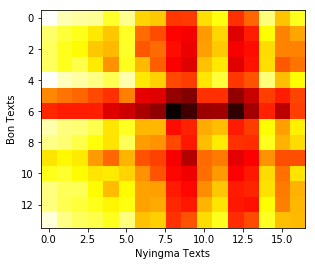

In [8]:
plt.imshow(cos_sims, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

Legend:

In [9]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [10]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 1b: Pairwise cosine similarity of term frequency vectors (filtered)

In [11]:
filter_list = ['གི','ལ','གིས','དང','ནི','ནས','པ','གོ','ཀྱང','དུ','ཀྱིས','དེ','ཏེ','མ','སྟེ','སུ','ཀྱི','གྱིས','ན','ཅེས','འདི','གྱི','ཅི','བ','པར','ཡིས','ཅིང','མོ','ཅེས་པ','རྣམས','ཏུ']

bon_texts_f = []
for t in bon_texts:
    t_f = [x for x in t if x not in filter_list]
    bon_texts_f.append(t_f)

nyingma_texts_f = []
for t in nyingma_texts:
    t_f = [x for x in t if x not in filter_list]
    nyingma_texts_f.append(t_f)

In [12]:
dct_f = Dictionary(bon_texts_f + nyingma_texts_f)

In [13]:
bon_bows_f = []
for t in bon_texts_f:
    bon_bows_f.append(dct_f.doc2bow(t))
    
nyingma_bows_f = []
for t in nyingma_texts_f:
    nyingma_bows_f.append(dct_f.doc2bow(t))

In [14]:
bon_tfs_f = []
for t in bon_bows_f:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    bon_tfs_f.append(vec)
    
nyingma_tfs_f = []
for t in nyingma_bows_f:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_f.append(vec)

In [15]:
cos_sims_f = np.zeros((len(bon_tfs_f), len(nyingma_tfs_f)))

for i in range(len(bon_tfs_f)):
    for j in range(len(nyingma_tfs_f)):
        u = bon_tfs_f[i]
        v = nyingma_tfs_f[j]
        cos_sims_f[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

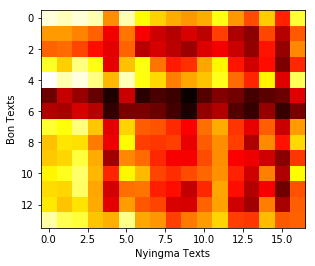

In [16]:
plt.imshow(cos_sims_f, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

Legend:

In [17]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [18]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 2a: Pairwise cosine similarity of 2-gram frequency vectors

In [19]:
bon_bigrams = []
for t in bon_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2)]
    bon_bigrams.append(grams)
    
nyingma_bigrams = []
for t in nyingma_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2)]
    nyingma_bigrams.append(grams)

In [20]:
dct_bigrams = Dictionary(bon_bigrams + nyingma_bigrams)

In [21]:
bon_bows_bigrams = []
for t in bon_bigrams:
    bon_bows_bigrams.append(dct_bigrams.doc2bow(t))
    
nyingma_bows_bigrams = []
for t in nyingma_bigrams:
    nyingma_bows_bigrams.append(dct_bigrams.doc2bow(t))

In [22]:
bon_tfs_bigrams = []
for t in bon_bows_bigrams:
    vec = np.zeros(len(dct_bigrams))
    for k, v in t:
        vec[k] = v
    bon_tfs_bigrams.append(vec)
    
nyingma_tfs_bigrams = []
for t in nyingma_bows_bigrams:
    vec = np.zeros(len(dct_bigrams))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_bigrams.append(vec)

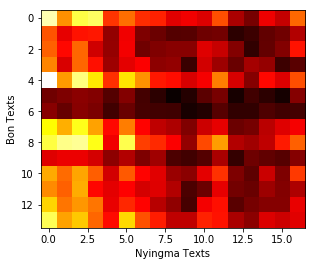

In [23]:
cos_sims_bigrams = np.zeros((len(bon_tfs_bigrams), len(nyingma_tfs_bigrams)))

for i in range(len(bon_tfs_bigrams)):
    for j in range(len(nyingma_tfs_bigrams)):
        u = bon_tfs_bigrams[i]
        v = nyingma_tfs_bigrams[j]
        cos_sims_bigrams[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_bigrams, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

Legend:

In [24]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [25]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 2b: Pairwise cosine similarity of 2-gram frequency vectors (filtered)

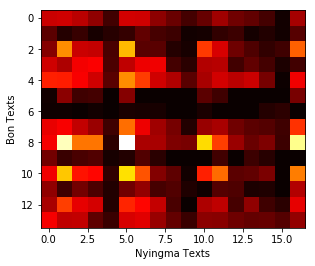

In [26]:
bon_bigrams_f = []
for t in bon_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2) if not set(x).intersection(filter_list)]
    bon_bigrams_f.append(grams)
    
nyingma_bigrams_f = []
for t in nyingma_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2) if not set(x).intersection(filter_list)]
    nyingma_bigrams_f.append(grams)
    
dct_bigrams_f = Dictionary(bon_bigrams_f + nyingma_bigrams_f)

bon_bows_bigrams_f = []
for t in bon_bigrams_f:
    bon_bows_bigrams_f.append(dct_bigrams_f.doc2bow(t))
    
nyingma_bows_bigrams_f = []
for t in nyingma_bigrams_f:
    nyingma_bows_bigrams_f.append(dct_bigrams_f.doc2bow(t))
    
bon_tfs_bigrams_f = []
for t in bon_bows_bigrams_f:
    vec = np.zeros(len(dct_bigrams_f))
    for k, v in t:
        vec[k] = v
    bon_tfs_bigrams_f.append(vec)
    
nyingma_tfs_bigrams_f = []
for t in nyingma_bows_bigrams_f:
    vec = np.zeros(len(dct_bigrams_f))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_bigrams_f.append(vec)

cos_sims_bigrams_f = np.zeros((len(bon_tfs_bigrams_f), len(nyingma_tfs_bigrams_f)))

for i in range(len(bon_tfs_bigrams_f)):
    for j in range(len(nyingma_tfs_bigrams_f)):
        u = bon_tfs_bigrams_f[i]
        v = nyingma_tfs_bigrams_f[j]
        cos_sims_bigrams_f[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_bigrams_f, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

In [27]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [28]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 3a: Pairwise cosine similarity of word + 2-gram frequency

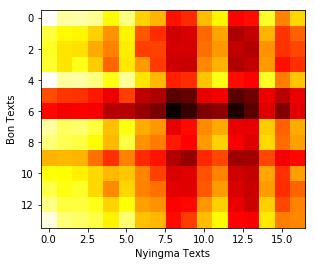

In [29]:
bon_words_bigrams = []
for t1, t2 in zip(bon_texts, bon_bigrams):
    bon_words_bigrams.append(t1 + t2)
    
nyingma_words_bigrams = []
for t1, t2 in zip(nyingma_texts, nyingma_bigrams):
    nyingma_words_bigrams.append(t1 + t2)
    
dct_words_bigrams = Dictionary(bon_words_bigrams + nyingma_words_bigrams)

bon_bows_words_bigrams = []
for t in bon_words_bigrams:
    bon_bows_words_bigrams.append(dct_words_bigrams.doc2bow(t))
    
nyingma_bows_words_bigrams = []
for t in nyingma_words_bigrams:
    nyingma_bows_words_bigrams.append(dct_words_bigrams.doc2bow(t))
    
bon_tfs_words_bigrams = []
for t in bon_bows_words_bigrams:
    vec = np.zeros(len(dct_words_bigrams))
    for k, v in t:
        vec[k] = v
    bon_tfs_words_bigrams.append(vec)
    
nyingma_tfs_words_bigrams = []
for t in nyingma_bows_words_bigrams:
    vec = np.zeros(len(dct_words_bigrams))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_words_bigrams.append(vec)

cos_sims_words_bigrams = np.zeros((len(bon_tfs_words_bigrams), len(nyingma_tfs_words_bigrams)))

for i in range(len(bon_tfs_words_bigrams)):
    for j in range(len(nyingma_tfs_words_bigrams)):
        u = bon_tfs_words_bigrams[i]
        v = nyingma_tfs_words_bigrams[j]
        cos_sims_words_bigrams[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_words_bigrams, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

In [30]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [31]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 3b: Pairwise cosine similarity of word + 2-gram frequency (filtered)

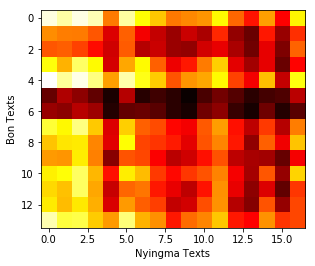

In [32]:
bon_words_bigrams_f = []
for t1, t2 in zip(bon_texts_f, bon_bigrams_f):
    bon_words_bigrams_f.append(t1 + t2)
    
nyingma_words_bigrams_f = []
for t1, t2 in zip(nyingma_texts_f, nyingma_bigrams_f):
    nyingma_words_bigrams_f.append(t1 + t2)
    
dct_words_bigrams_f = Dictionary(bon_words_bigrams_f + nyingma_words_bigrams_f)

bon_bows_words_bigrams_f = []
for t in bon_words_bigrams_f:
    bon_bows_words_bigrams_f.append(dct_words_bigrams_f.doc2bow(t))
    
nyingma_bows_words_bigrams_f = []
for t in nyingma_words_bigrams_f:
    nyingma_bows_words_bigrams_f.append(dct_words_bigrams_f.doc2bow(t))
    
bon_tfs_words_bigrams_f = []
for t in bon_bows_words_bigrams_f:
    vec = np.zeros(len(dct_words_bigrams_f))
    for k, v in t:
        vec[k] = v
    bon_tfs_words_bigrams_f.append(vec)
    
nyingma_tfs_words_bigrams_f = []
for t in nyingma_bows_words_bigrams_f:
    vec = np.zeros(len(dct_words_bigrams_f))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_words_bigrams_f.append(vec)

cos_sims_words_bigrams_f = np.zeros((len(bon_tfs_words_bigrams_f), len(nyingma_tfs_words_bigrams_f)))

for i in range(len(bon_tfs_words_bigrams_f)):
    for j in range(len(nyingma_tfs_words_bigrams_f)):
        u = bon_tfs_words_bigrams_f[i]
        v = nyingma_tfs_words_bigrams_f[j]
        cos_sims_words_bigrams_f[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_words_bigrams_f, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

In [33]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [34]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 4a: Pairwise Spearman Rank Correlation of common words and 2-grams (filtered)

In [35]:
ctr_words_f = Counter()
for t in bon_texts_f + nyingma_texts_f:
    ctr_words_f.update(t)
    
ctr_bigrams_f = Counter()
for t in bon_bigrams_f + nyingma_bigrams_f:
    ctr_bigrams_f.update(t)

Percent of word count in top 100 words:

In [36]:
total = sum([x[1] for x in ctr_words_f.items()])
top_100 = sum([x[1] for x in ctr_words_f.most_common(100)])
print("{} / {} = {}".format(top_100, total, top_100/total))

21788 / 53177 = 0.409726009364951


Percent of bigram count in top 100 bigrams:

In [37]:
total = sum([x[1] for x in ctr_bigrams_f.items()])
top_100 = sum([x[1] for x in ctr_bigrams_f.most_common(100)])
print("{} / {} = {}".format(top_100, total, top_100/total))

3267 / 29662 = 0.11014092104375969


In [38]:
token2id = dct_words_bigrams_f.token2id
top_100_words = {token2id[x[0]] for x in ctr_words_f.most_common(100)}
top_100_bigrams = {token2id[x[0]] for x in ctr_bigrams_f.most_common(100)}

bon_top_100 = []
for b in bon_bows_words_bigrams_f:
    vec = np.zeros(200)
    i = 0
    for k, v in b:
        if k in top_100_words or k in top_100_bigrams:
            vec[i] = v
            i += 1
    bon_top_100.append(vec)
            
nyingma_top_100 = []
for b in nyingma_bows_words_bigrams_f:
    vec = np.zeros(200)
    i = 0
    for k, v in b:
        if k in top_100_words or k in top_100_bigrams:
            vec[i] = v
            i += 1
    nyingma_top_100.append(vec)

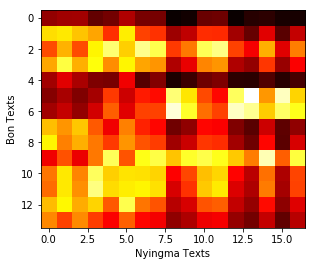

In [41]:
r_matrix = np.zeros((len(bon_texts), len(nyingma_texts)))

for i in range(len(bon_texts)):
    for j in range(len(nyingma_texts)):
        t, _ = stats.spearmanr(bon_top_100[i], nyingma_top_100[j])
        r_matrix[i, j] = t

plt.imshow(r_matrix, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()     

In [43]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [44]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 5: Pairwise Kendall's Tau-b of common words and 2-grams (filtered)

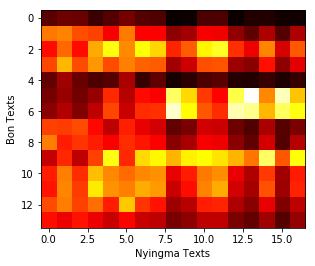

In [42]:
tau_matrix = np.zeros((len(bon_texts), len(nyingma_texts)))

for i in range(len(bon_texts)):
    for j in range(len(nyingma_texts)):
        t, _ = stats.kendalltau(bon_top_100[i], nyingma_top_100[j])
        tau_matrix[i, j] = t

plt.imshow(tau_matrix, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()     

In [45]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [46]:
nyingma_idx2fname

{0: "L1-rig-pa'i-khu-byug_p302-324.txt",
 1: 'L2-rtsal-chen_p436-447་.txt',
 2: 'L3-khyung-chen_p447-468.txt',
 3: 'L4_byang-sems-bsgom-rdo-la-gser-zhun-p416-425.txt',
 4: "L5_nam-mkha'-che-rgyas-pa-yi-ge-med-pa_V8-p.468-473.txt",
 5: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 6: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 7: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 8: 'LL04_byang-chub-sems-tig.txt',
 9: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 10: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 11: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 12: 'LL09_spyi-gcod_vol8_p.498.txt',
 13: 'LL10_yid-bzhin-nor-bu-431.txt',
 14: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 15: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 16: 'LL13-sgom-pa-don-grubdocx.txt'}

## Intermission: word and bigram frequencies (filtered)

In [51]:
bon_words_f = Counter(list(itertools.chain(*bon_texts_f)))
nyingma_words_f = Counter(list(itertools.chain(*nyingma_texts_f)))

bon_bigrams_f = Counter(list(itertools.chain(*bon_bigrams_f)))
nyingma_bigrams_f = Counter(list(itertools.chain(*nyingma_bigrams_f)))

In [55]:
print("Top 100 words")
for k, v in bon_words_f.most_common(100):
    print("{}: {}\n".format(k, v))

print("Top 100 words")
for k, v in nyingma_words_f.most_common(100):
    print("{}: {}\n".format(k, v))

print("Top 100 bigrams")
for k, v in bon_bigrams_f.most_common(100):
    print("{}: {}\n".format(k, v))

print("Top 100 bigrams")
for k, v in nyingma_bigrams_f.most_common(100):
    print("{}: {}\n".format(k, v))

Top 100 words
སེམས: 701

མི: 624

ལས: 513

མྱེད: 443

དོན: 435

བྱ: 419

ཉིད: 403

ཡེ་ཤེས: 332

ཐམས་ཅད: 313

བོན: 297

ཡིན: 270

ངང: 268

མེད་པ: 257

བྱང་ཆུབ: 255

མཚན་མ: 249

གསལ་བ: 238

ཆེན་པོ: 232

ཁུ་བྱུག: 221

གསུམ: 215

བདག: 206

རིག་པ: 200

གཉིས: 198

མེད: 196

ལུང: 188

ནམ་མཁའ: 184

གསལ: 182

བྱ་བ: 178

དབྱིངས: 177

ཞིང: 177

གནས: 172

ལྷ: 171

དུས: 165

བསྒོམ: 161

སེམས་ཉིད: 159

སྟོན་པ: 158

ལྔ: 157

རང་བཞིན: 157

རང: 156

རྟོགས: 156

ཀུན: 155

ཙམ: 149

ཡེ་ནས: 146

པས: 138

འོད: 136

བཞི: 135

བསྟན་པ: 135

ཤེས་པ: 134

སྤྲུལ་པ: 133

ལྟར: 132

སྐྱེ་བ: 131

རྟོགས་པ: 128

རྣམ་པར: 123

ཏིང་ངེ་འཛིན: 121

འབྱུང: 119

བྱུང: 116

གཤེན: 115

ཡིད: 113

ཅིག: 112

སྐུ: 112

སེམས་ཅན: 111

གནས་པ: 111

བརྣན: 111

སྣང: 110

ཅན: 110

ཐབས: 108

དེས: 105

དེ་ལྟར: 105

བདེ་བ: 104

སྟོན: 102

རྣམ་པ: 102

བག་ཆགས: 102

འདྲ: 102

རུ: 102

བཤད: 101

པོ: 101

གཤེན་ལྷ: 96

ལུས: 96

གཅིག: 95

ལྡན་པ: 93

རྒྱུ: 90

དོན་དམ: 89

བསྒོམ་པ: 89

གང: 88

ཐིག་ལེ: 88

འབྲས་བུ: 86

རྒྱལ་པོ: 86

མན་ངག: 85

གཡུང་དྲུང: